In [1]:
import pygmt 
import pandas as pd
import numpy as np
import xarray as xr
import warnings
import os
import glob
from obspy import geodetics
warnings.filterwarnings('ignore')

In [2]:
def read_model():
    vel = xr.open_dataset('TGR_data'+os.sep+'tomoDD09'+os.sep+'TGR_2009_velocity_3_19.h5')
    chk = xr.open_dataset('TGR_data'+os.sep+'tomoDD09'+os.sep+'TGR_2009_checkerboard_3_19.h5')
    ds_vel = vel[['vp_0','vs_0','vpvs_0','dwsp','dwss','vp','vs','vpvs']]
    ds_chk = chk[['vp_0','vs_0','vpvs_0','vp_true','vs_true','vpvs_true','vp_perc','vs_perc','res_p','res_s']]
    return ds_vel,ds_chk

In [3]:
# read the model
clat,clon = 31.0,110.5
vel,chk = read_model()
lons,lats,deps= vel.longitude.values,vel.latitude.values,vel.depth.values
lon1,lon2 = min(lons),max(lons)
lat1,lat2 = min(lats),max(lats)
dep1,dep2 = min(deps),max(deps)

# 插值网格
delta = geodetics.kilometer2degrees(1.0)
new_lons = np.arange(lon1,lon2+delta,delta)
new_lats = np.arange(lat1,lat2+delta,delta)
#new_lons = np.linspace(lon1, lon2, len(lons) * 3)
#new_lats = np.linspace(lat1, lat2, len(lats) * 3)
deps = np.arange(dep1,dep2+0.1,0.1)
model = vel.interp(longitude=new_lons,latitude=new_lats)
chk = chk.interp(longitude=new_lons,latitude=new_lats)


In [4]:
# read the catalog
names = ['evtid','latitude','longitude','depth','X','Y','Z','ex','ey','ez',
         'year','month','day','hour','minute','second','magnitude',
         'nccp','nccs','nctp','ncts','rcc','rct','cid']
catalog = pd.read_csv('TGR_data/tomoDD09/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)
cities = pd.read_csv('TGR_data/geology/SX_citylonlat.txt',sep='\s+',encoding='gbk')

In [5]:
def plotvpvs(fig,model,catalog,depth,wave='vp',interval=100):
    depths = model.depth.values
    #depths = np.array([ 0.,  2.,  5.,  8., 11., 14., 20.])
    grid_vp = model.vp.sel(depth=depth)
    grid_vp0 = model.vp_0.sel(depth=depth)
    grid_dwsp = model.dwsp.sel(depth=depth)
    grid_resp = chk.res_p.sel(depth=depth)
    grid_vp = 100*(grid_vp-grid_vp0)/grid_vp0
    cmap = 'seis'
    if wave == 'vs':
        grid_vp = model.vs.sel(depth=depth)
        grid_vp0 = model.vs_0.sel(depth=depth)
        grid_dwsp = model.dwss.sel(depth=depth)
        grid_resp = chk.res_s.sel(depth=depth)
        grid_vp = 100*(grid_vp-grid_vp0)/grid_vp0
        cmap = 'roma'
    frame =  ['xaf','y+lref:%.2fkm/s'%(grid_vp0.data[0][0])]
    if wave == 'vpvs':
        grid_vp = model.vp.sel(depth=depth)/model.vs.sel(depth=depth)
        grid_dwsp = model.dwsp.sel(depth=depth)
        grid_resp = chk.res_p.sel(depth=depth)
        cmap='polar'
        frame =  ['xaf']
    clip = grid_dwsp.where(grid_dwsp>=interval,drop=False)
    clip_out = grid_dwsp.where(grid_dwsp < interval,drop=False)
    if interval < 1:
        clip = grid_resp.where(grid_resp >= interval,drop=False)
        clip_out = grid_resp.where(grid_resp < interval,drop=False)
        grid_dwsp = grid_resp
    
    mask_out = clip_out*0 + 1
    grid_vp_out = grid_vp*mask_out
    
    mask = clip*0+1
    grid_vp = grid_vp*mask
    
    #pygmt.grd2cpt(grid=grid_vp,cmap=cmap,overrule_bg=True,continuous=True,background=True)
    pygmt.makecpt(cmap=cmap,series=[-15,15,0.1],continuous=True,overrule_bg=True,background=True)
    if wave == 'vpvs':
        pygmt.makecpt(cmap=cmap,series=[1.6,2.0,0.1],overrule_bg=True,continuous=True,background=True,reverse=False)
    fig.grdimage(grid=grid_vp_out,cmap=True,transparency=50,nan_transparent=True)
    fig.grdimage(grid=grid_vp,cmap=True,nan_transparent=True)
    fig.grdcontour(grid=grid_dwsp,interval=interval,limit=[interval,interval],pen='1.0p,white')

    # plot the earthquake
    if depth == depths[0]:
        z2 = (depths[1]+depth)/2
        reloc = catalog[catalog.depth <= z2]
    elif depth == depths[-1]:
        z1 = (depths[-2]+depth)/2
        reloc = catalog[catalog.depth >= z1]
    else:
        index = np.where(depths == depth)[0][0]
        z1 = (depths[index-1]+depth)/2
        z2 = (depths[index+1]+depth)/2
        reloc = catalog[(catalog.depth >= z1)&(catalog.depth<=z2)]
    
    fig.plot(x=reloc.longitude,y=reloc.latitude,style='c0.03i',fill='white',pen='0.1p')
    fig.plot(data='TGR_data/geology/Presinian.gmt',pen='0.5p,240/143/117',close=True)
    fig.plot(data='TGR_data/geology/Jurassic.gmt',pen='0.5p,181/204/227',close=True)

    fig.plot(data='TGR_data/geology/Faults.gmt',pen='0.5p,gray17')
    # plot the rivers
    fig.plot(data='TGR_data/geology/HYDA.gmt',pen='0.1p,0/112/255',fill='0/112/255',close=True,transparency=30)
    fig.plot(data='TGR_data/geology/Rivers.gmt',pen='0.5p,0/112/255',close=False,transparency=30) # Yangtze river
    
    # mark the main cites
    #fig.plot(x=cities.longitude,y=cities.latitude,style='c0.04i',fill='black')
    c_list = ['Sanxi','Yanduhe','Gaoyang','Badong','Chadianzi','Xietan','Meijiahe','Lianghekou','Guojiaba','Jiuwanxi','Zigui']
    c_cities = cities[cities.name_en.isin(c_list)]
    if depth == 0.0 and wave == 'vp':
        for i in range(len(c_cities)):
            line = c_cities.iloc[i]
            lon,lat,name = line.longitude,line.latitude,line.name_en
            justify = 'ML'
            offset = '0.1c/0.0c'
            if name =='Badong':offset='-0.1c/-0.2c'
            if name =='Gaoyang':offset='-1.3c/0.1c'
            if name =='Xietan':offset='0.0c/-0.3c'
            if name == 'Lianghekou':offset='-1.3c/-0.3c'
            if name == 'Guojiaba':offset='0.1c/0.2c'
            if name == 'Jiuwanxi':offset='-0.2c/-0.3c'
            if name == 'Zigui':offset='-0.6c/-0.2c'

            fig.text(x=lon,y=lat,text=name,font='7p',justify=justify,fill='white',offset=offset)
    fig.plot(x=c_cities.longitude,y=c_cities.latitude,style='c0.04i',fill='black')

    with pygmt.config(MAP_FRAME_PEN='0.2p'):fig.colorbar(position='jBL+w2c/0.25c+o0.2c/0.1c+h+m+e',cmap=True,frame=frame)
    #fig.colorbar(position='jBL+w2c/0.25c+o0.1c/0.1c+h+m+e',cmap=True,frame=['xaf','y+lkm/s'])
    #fig.colorbar(position='jMR+w3.0c/0.3c+o-0.6c/0c+m+e',frame=['xaf','y+lkm/s'])
    return fig

In [6]:
def plot_depth(fig,model,catalog,region,interval=100,depth=None,frame='wsen+g128'):
    fig = plotvpvs(fig,model,catalog,depth=depth,wave='vp',interval=interval)
    fig.text(position='cTL',text='Vp',offset='0.1c/-0.1c',fill='white')
    fig.text(position='MC',text='Depth={}km'.format(depth),angle=90,offset='-5.4c/0c',font='8p,5',no_clip=True)

    fig.shift_origin(xshift='{}c'.format(width+0.5))
    fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf',frame])
    fig = plotvpvs(fig,model,catalog,depth=depth,wave='vs',interval=interval)
    fig.text(position='cTL',text='Vs',offset='0.1c/-0.1c',fill='white')

    fig.shift_origin(xshift='{}c'.format(width+0.5))
    fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf',frame])
    fig = plotvpvs(fig,model,catalog,depth=depth,wave='vpvs',interval=interval)
    fig.text(position='cTL',text='Vp/Vs',offset='0.1c/-0.1c',fill='white')
    return fig

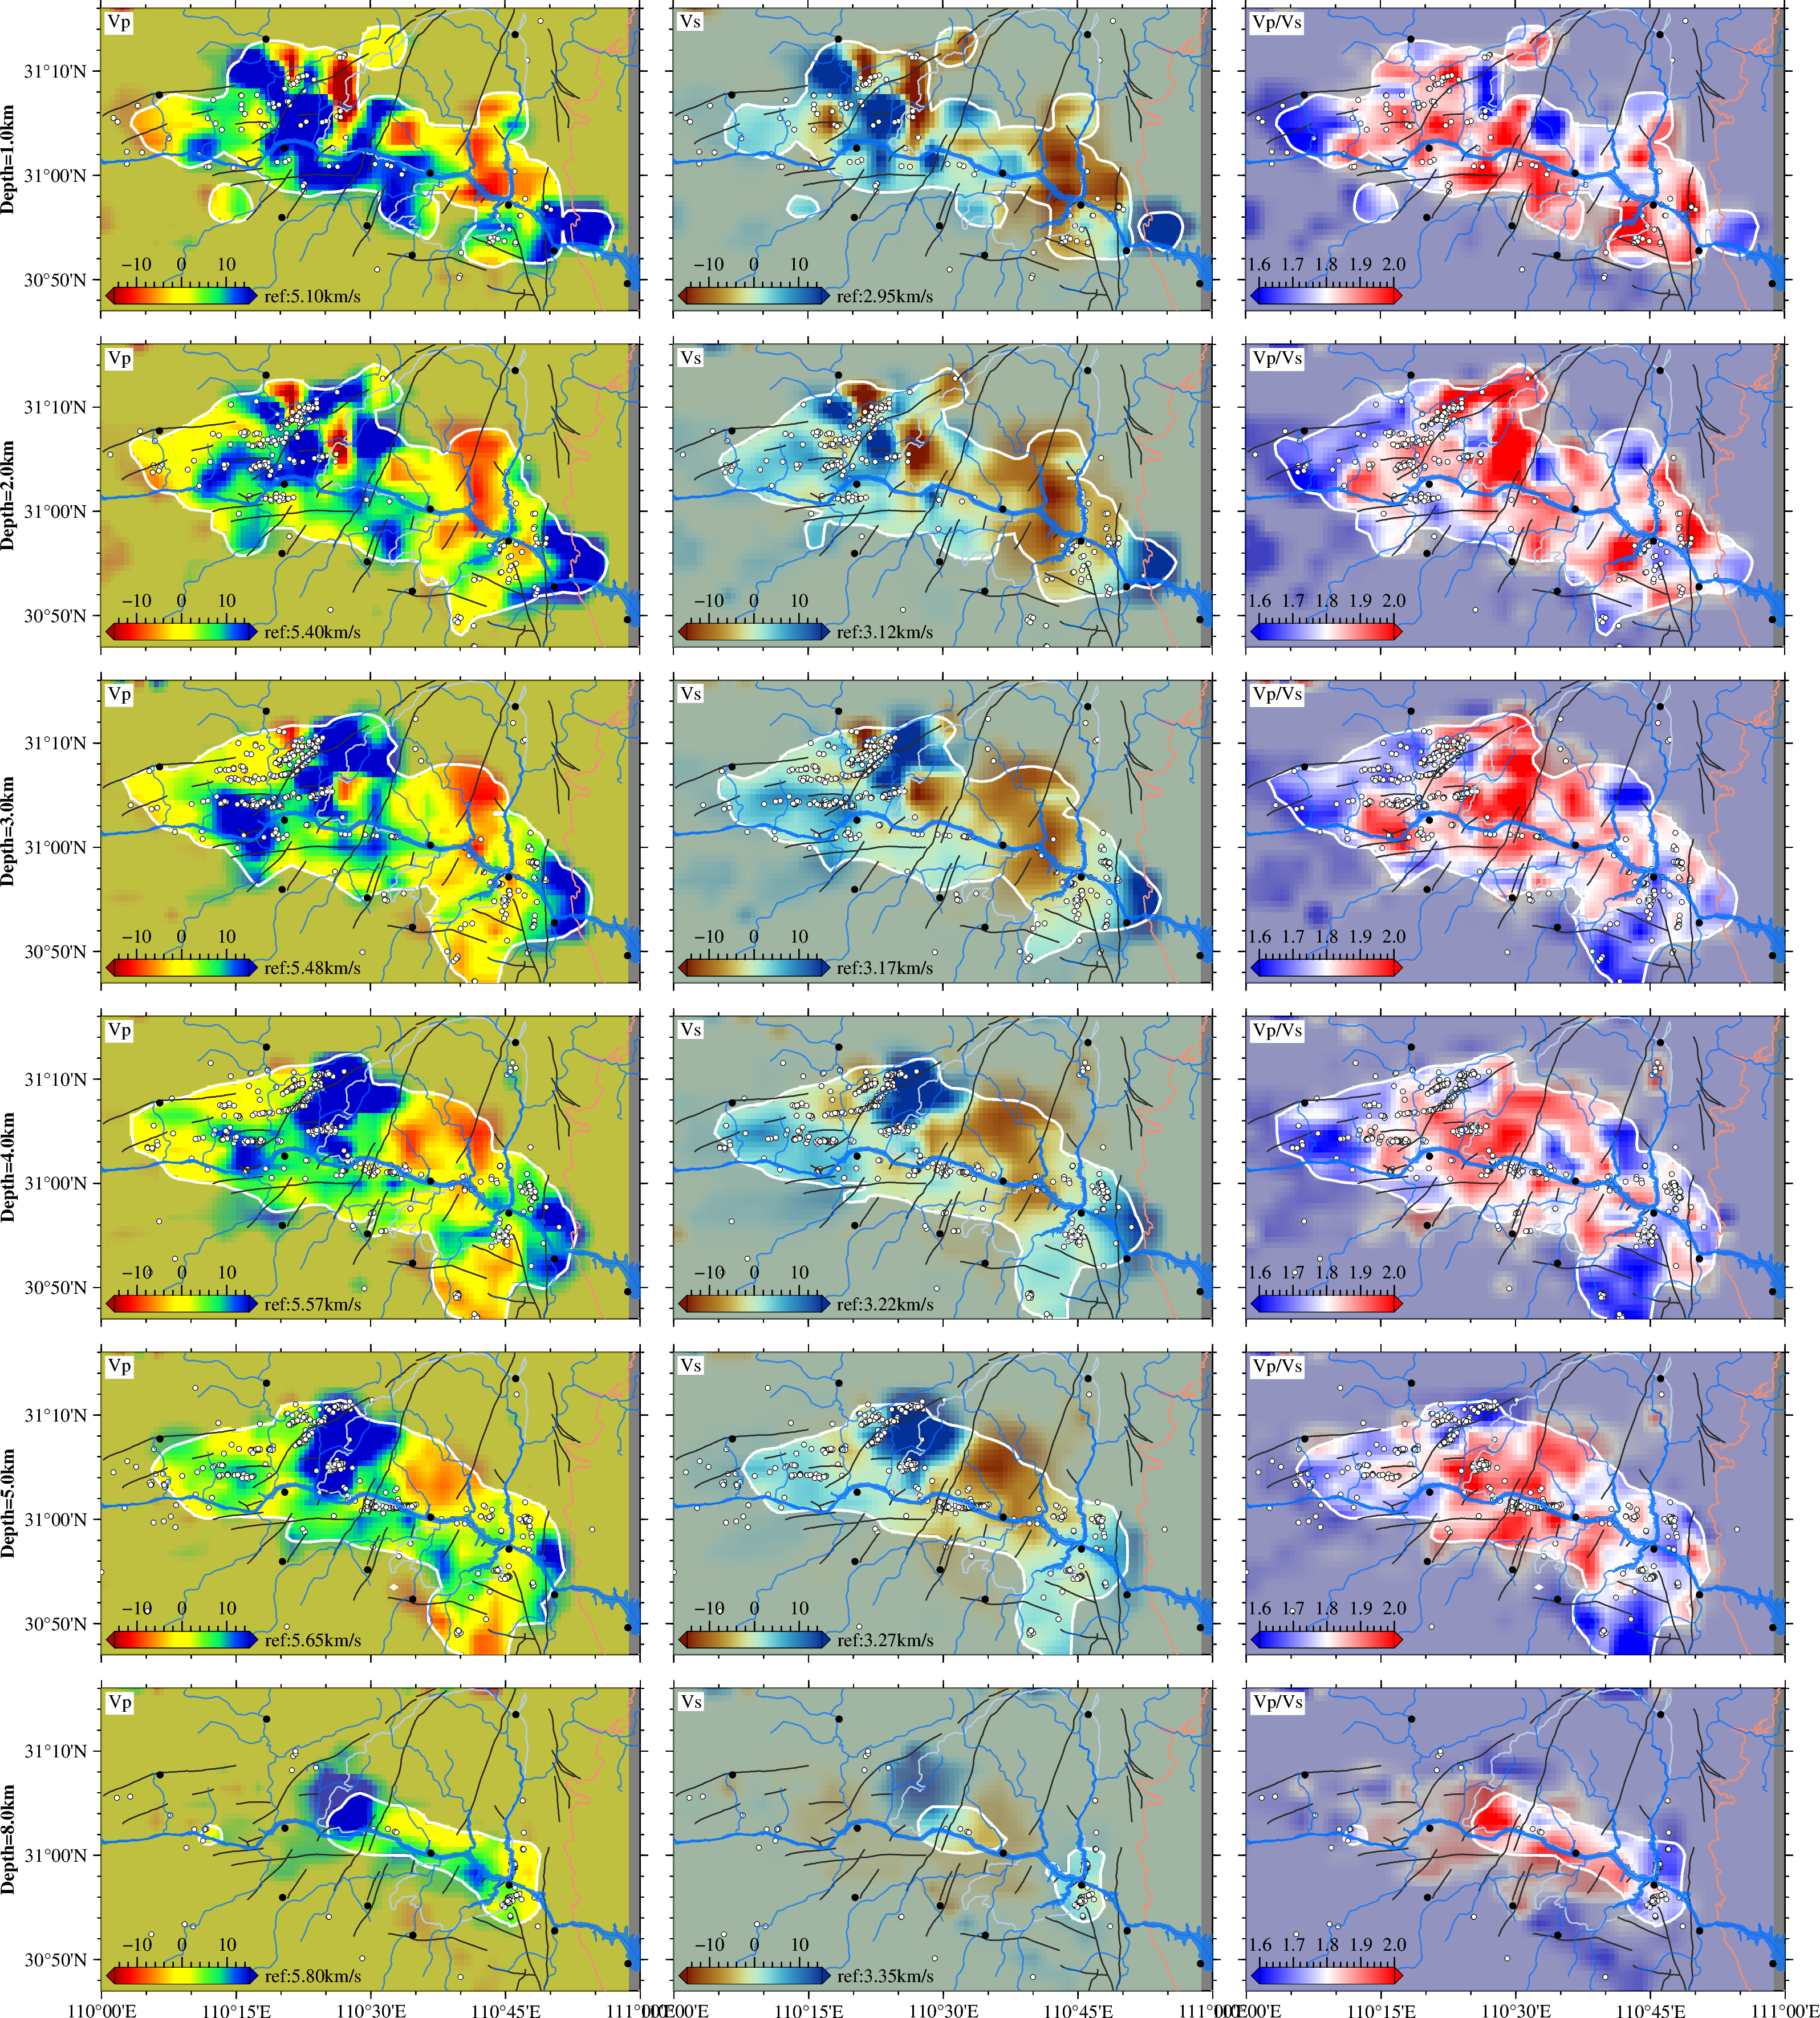

In [7]:
# 绘制Vp/Vs
interval = 100
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd:mm:ssF',FONT='8p,4',COLOR_NAN='128',MAP_FRAME_TYPE='plain',MAP_FRAME_PEN='0.5p')
#region = pygmt.info(data=velocity[['longitude','latitude']],per_column=True)
region = [110,111,30+40/60,31+20/60]
region = [110,111,30+47/60,31+16/60]
width = 8
scale = width/(region[1]-region[0])
fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf','Wsen+g128'])
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"-Wh ->{tmpfile.name}")
        map_height = tmpfile.read().strip()
map_height = float(map_height)
#==================================1.0km
fig = plot_depth(fig,model,catalog,region,depth=1.0,interval=interval)

#==================================2.0km
fig.shift_origin(xshift='-{}c'.format(2*(width+0.5)),yshift='-{}c'.format(map_height+0.5))
fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf','Wsen+g128'])
fig = plot_depth(fig,model,catalog,region,depth=2.0,interval=interval)

#==================================3.0km
fig.shift_origin(xshift='-{}c'.format(2*(width+0.5)),yshift='-{}c'.format(map_height+0.5))
fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf','Wsen+g128'])
fig = plot_depth(fig,model,catalog,region,depth=3.0,interval=interval)

#==================================4.0km
fig.shift_origin(xshift='-{}c'.format(2*(width+0.5)),yshift='-{}c'.format(map_height+0.5))
fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf','Wsen+g128'])
fig = plot_depth(fig,model,catalog,region,depth=4.0,interval=interval)

#==================================5.0km
fig.shift_origin(xshift='-{}c'.format(2*(width+0.5)),yshift='-{}c'.format(map_height+0.5))
fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf','Wsen+g128'])
fig = plot_depth(fig,model,catalog,region,depth=5.0,interval=interval)

#==================================6.0km
#fig.shift_origin(xshift='-{}c'.format(2*(width+0.5)),yshift='-{}c'.format(map_height+0.5))
#fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf','Wsen+g128'])
#fig = plot_depth(fig,model,catalog,region,depth=6.0)

#==================================7.0km
#fig.shift_origin(xshift='-{}c'.format(2*(width+0.5)),yshift='-{}c'.format(map_height+0.5))
#fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf','Wsen+g128'])
#fig = plot_depth(fig,model,catalog,region,depth=7.0)

#==================================8.0km
fig.shift_origin(xshift='-{}c'.format(2*(width+0.5)),yshift='-{}c'.format(map_height+0.5))
fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf','WSen+g128'])
fig = plot_depth(fig,model,catalog,region,depth=8.0,interval=interval,frame='wSen+g128')

'''
#==================================11.0km
fig.shift_origin(xshift='-{}c'.format(2*(width+0.2)),yshift='-{}c'.format(map_height+0.2))
fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf','WSen'])
fig = plotvpvs(fig,model,catalog,depth=11.0,tp='vp')
fig.text(position='cTL',text='Vp',offset='0.1c/-0.1c',fill='white')
fig.text(position='MC',text='Depth=11.0km',angle=90,offset='-5.4c/0c',font='8p,5',no_clip=True)

fig.shift_origin(xshift='{}c'.format(width+0.2))
fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf','wSen'])
fig = plotvpvs(fig,model,catalog,depth=11.0,tp='vs')
fig.text(position='cTL',text='Vs',offset='0.1c/-0.1c',fill='white')

fig.shift_origin(xshift='{}c'.format(width+0.2))
fig.basemap(region=region,projection='m{}c'.format(scale),frame=['xaf','yaf','wSen'])
fig = plotvpvs(fig,model,catalog,depth=11.0,tp='vpvs')
fig.text(position='cTL',text='Vp/Vs',offset='0.1c/-0.1c',fill='white')
'''
fig.show()

In [8]:
fig.savefig('plotting_figures'+os.sep+'Figure12_Vp_Vs.pdf')
fig.savefig('plotting_figures'+os.sep+'Figure12_Vp_Vs.png',dpi=600)

In [9]:
for file in glob.glob('*.cpt'):
    os.remove(file)